# 2 - Exploratory Analysis

### Imports and Processed Data Fetch

In [1]:
import pandas as pd
import pathlib
import os
import pickle
import matplotlib.pyplot as plt

**Obs:** Just run the followin cell *once* as it alters the working directory path.

In [2]:
# Setting project root directory to work with scripts folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(project_root)

print("Current Working Directory:", os.getcwd())    

Current Working Directory: /home/gabrielhso/Desktop/northumbria/data-analytics/project-repo


In [3]:
DATA_DIR = pathlib.Path.cwd() / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
with open(PROCESSED_DATA_DIR / 'preprocessed.pkl', 'rb') as f:
    preprocessed_df = pickle.load(f)

preprocessed_df.head()

,Dst Port,Protocol,Flow Duration,Timestamp,Tot Fwd Pkts,Tot Bwd Pkts,Malicious,FTP-BruteForce,SSH-Bruteforce
0,0,0,112641719,2018-02-14 08:31:01,3,0,0,0,0
1,0,0,112641466,2018-02-14 08:33:50,3,0,0,0,0
2,0,0,112638623,2018-02-14 08:36:39,3,0,0,0,0
3,22,6,6453966,2018-02-14 08:40:13,15,10,0,0,0
4,22,6,8804066,2018-02-14 08:40:23,14,11,0,0,0


## Exploratory Analysis and Additional Data Processing

### Protocol

As we are interested in investigating the SSH and FTP brute force attack, that is done using TCP packets, let's filter out all entries of packets with Protocol different from 6 (SSH protocol number according to [IANA](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml)). We can also dismiss this column now.

In [4]:
filtered_df = preprocessed_df[preprocessed_df['Protocol'] == 6].copy()
filtered_df.drop(columns=['Protocol'], inplace=True)

**Dst Port**

Refers to destined port of the protocol. We are interested in a range of ports, as the SSH protocol uses an ephemeral port to send back ACK and RST flags. [SSH uses port 22](https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml?search=ssh), whilst [FTP uses ports 20 and 21](https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml?search=ftp) (IANA).
Both protocols use supporting ports as well, but for the sakes of simplicity they will not be considered.

In [5]:
filtered_df['Dst Port'].value_counts()

Dst Port
21       193428
22       187881
80       130899
443       92119
3389      90606
          ...  
59476         1
11053         1
44636         1
60594         1
65264         1
Name: count, Length: 18538, dtype: int64

In [6]:
print(filtered_df.size)
ssh_df = filtered_df[filtered_df['Dst Port'] == 22].copy()
ssh_df.drop('Dst Port', axis=1, inplace=True)
print(ssh_df.size)
ftp_df = filtered_df[(filtered_df['Dst Port'] == 21) | (filtered_df['Dst Port'] == 20) ].copy()
ftp_df.drop('Dst Port', axis=1, inplace=True)
print(ftp_df.size)
all_df = filtered_df.copy()
all_df.drop('Dst Port', axis=1, inplace=True)

6634472
1315167
1354003


### Grouping the dataset

In order to analyze the dataset as a time series it is necessary to group the dataset.

According to notebook 1, the packet capturing started at 01:00:00 and stopped at 12:59:59.

In [7]:
time_delta = pd.date_range(start='2018-02-14 01:00:00', end='2018-02-14 12:59:59', freq='min')
time_delta_df = pd.DataFrame(index=time_delta)

In [8]:
def floor_by_minutes(df: pd.DataFrame) -> pd.DataFrame:
    df['Minute'] = df['Timestamp'].dt.floor('min')
    df.drop('Timestamp', axis=1, inplace=True)
    return df

all_df = floor_by_minutes(all_df)
ssh_df = floor_by_minutes(ssh_df)
ftp_df = floor_by_minutes(ftp_df)

In [9]:
all_df.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Malicious,FTP-BruteForce,SSH-Bruteforce,Minute
3,6453966,15,10,0,0,0,2018-02-14 08:40:00
4,8804066,14,11,0,0,0,2018-02-14 08:40:00
5,6989341,16,12,0,0,0,2018-02-14 08:40:00
8,476513,5,3,0,0,0,2018-02-14 08:47:00
9,475048,5,3,0,0,0,2018-02-14 08:47:00


In [10]:
def group_by_minute(df: pd.DataFrame) -> pd.DataFrame:
    grouped_df = df.groupby('Minute').agg({
        'Tot Fwd Pkts': 'sum',
        'Tot Bwd Pkts': 'sum',
        'Flow Duration': 'sum',
        'Malicious': 'max'
    })
    
    df = pd.concat([time_delta_df, grouped_df], axis=1, sort=True)

    return grouped_df

all_df = group_by_minute(all_df)
ssh_df = group_by_minute(ssh_df)
ftp_df = group_by_minute(ftp_df)

all_df.head()

,Tot Fwd Pkts,Tot Bwd Pkts,Flow Duration,Malicious
Minute,,,,
2018-02-14 01:00:00,13888,17730,35802826873,0
2018-02-14 01:01:00,11909,20098,16922074020,0
2018-02-14 01:02:00,3760,2941,6879804215,0
2018-02-14 01:03:00,6612,10763,8333718014,0
2018-02-14 01:04:00,5708,6130,13561940836,0


# Plotting Data

According to the dataset description, the attacks happened during the following times:

In [11]:
# According to dataset description
SSH_ATTACK_START = pd.Timestamp('2018-02-14 02:01:00')
SSH_ATTACK_END = pd.Timestamp('2018-02-14 3:31:00')
FTP_ATTACK_START = pd.Timestamp('2018-02-14 10:32:00')
FTP_ATTACK_END = pd.Timestamp('2018-02-14 12:09:00')

### Plotting according to Total Packets

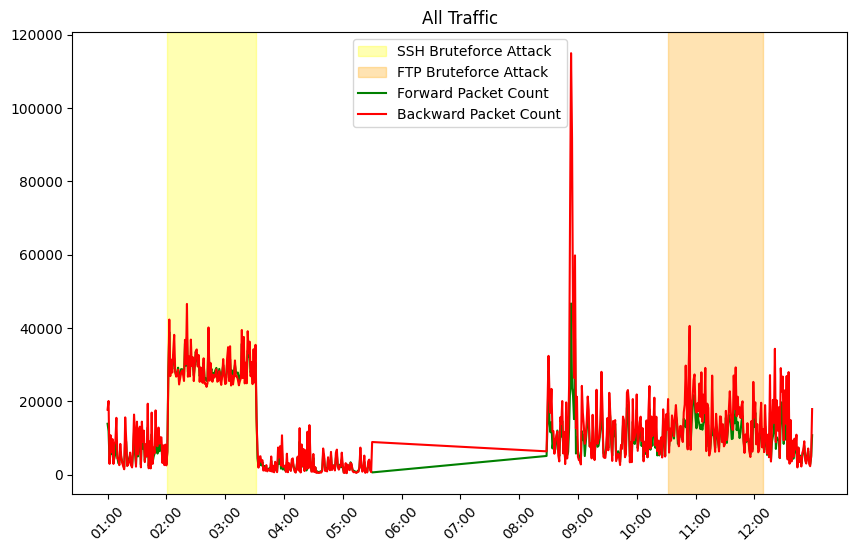

In [12]:
def plot_flags(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.axvspan(pd.Timestamp(SSH_ATTACK_START), pd.Timestamp(SSH_ATTACK_END), 
           color='yellow', alpha=0.3, label="SSH Bruteforce Attack")
    ax.axvspan(pd.Timestamp(FTP_ATTACK_START), pd.Timestamp(FTP_ATTACK_END), 
           color='orange', alpha=0.3, label="FTP Bruteforce Attack")

    ax.plot(df.index, df['Tot Fwd Pkts'], label='Forward Packet Count', color='green')
    ax.plot(df.index, df['Tot Bwd Pkts'], label='Backward Packet Count', color='red')

    # Reprocess x axis to show every hour
    plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='h'))
    plt.xticks(rotation=45)

    # Reprocess x axis labels to show only hour
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())
    ax.set_title(title)
    
    return fig, ax

fig, ax = plot_flags(all_df, 'All Traffic')


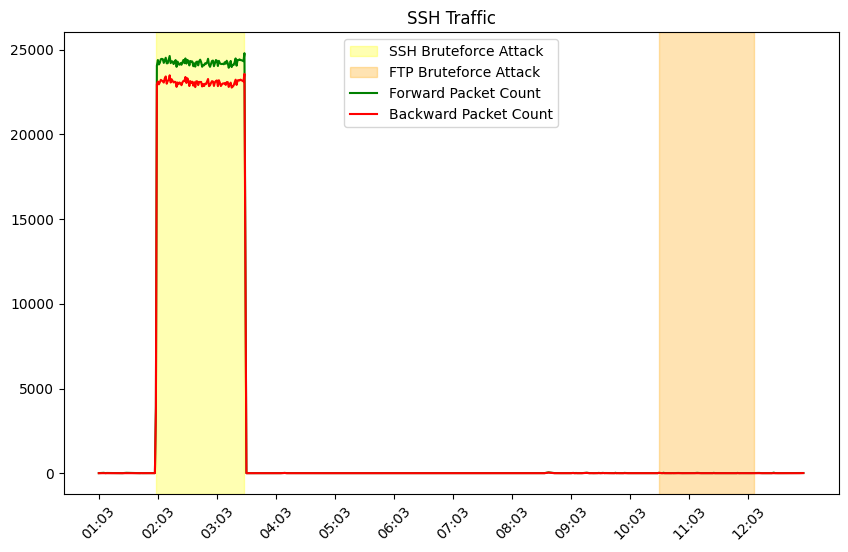

In [13]:
fig, ax = plot_flags(ssh_df, 'SSH Traffic')

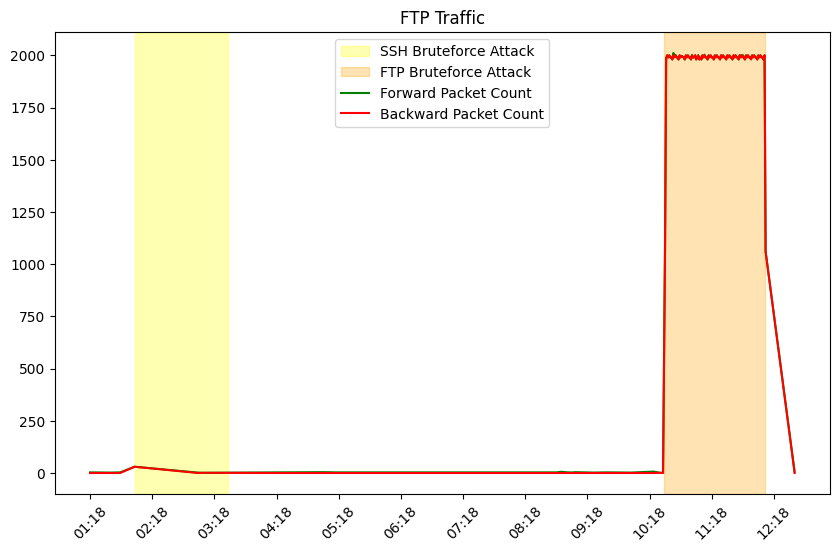

In [14]:
fig, ax = plot_flags(ftp_df, 'FTP Traffic')

### Plotting by Flow Duration

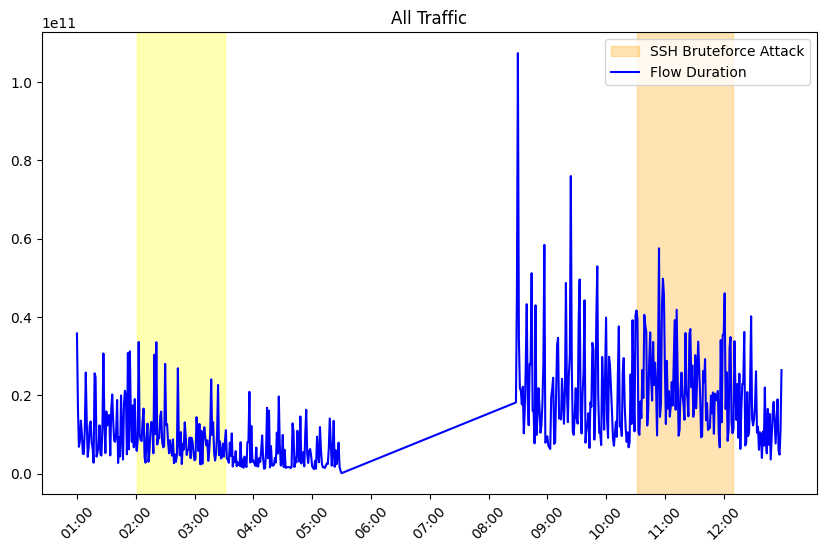

In [15]:
def plot_packets(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.axvspan(pd.Timestamp(SSH_ATTACK_START), pd.Timestamp(SSH_ATTACK_END), 
           color='yellow', alpha=0.3, label="SSH Bruteforce Attack")
    ax.axvspan(pd.Timestamp(FTP_ATTACK_START), pd.Timestamp(FTP_ATTACK_END), 
           color='orange', alpha=0.3, label="SSH Bruteforce Attack")

    ax.plot(df.index, df['Flow Duration'], label='Flow Duration', color='blue')

    # Reprocess x axis to show every hour
    plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='h'))
    plt.xticks(rotation=45)

    # Reprocess x axis labels to show only hour
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())
    ax.set_title(title)
    
    return fig, ax

fig, ax = plot_packets(all_df, 'All Traffic')

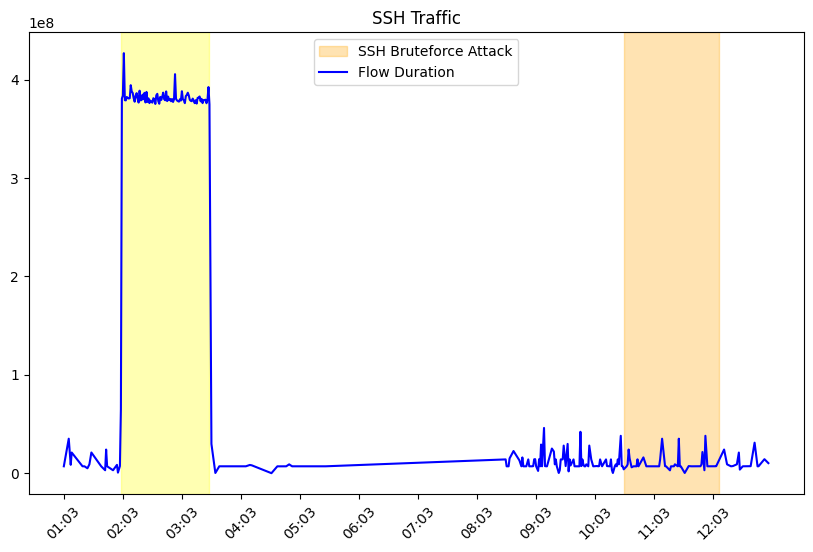

In [16]:
fig, ax = plot_packets(ssh_df, 'SSH Traffic')

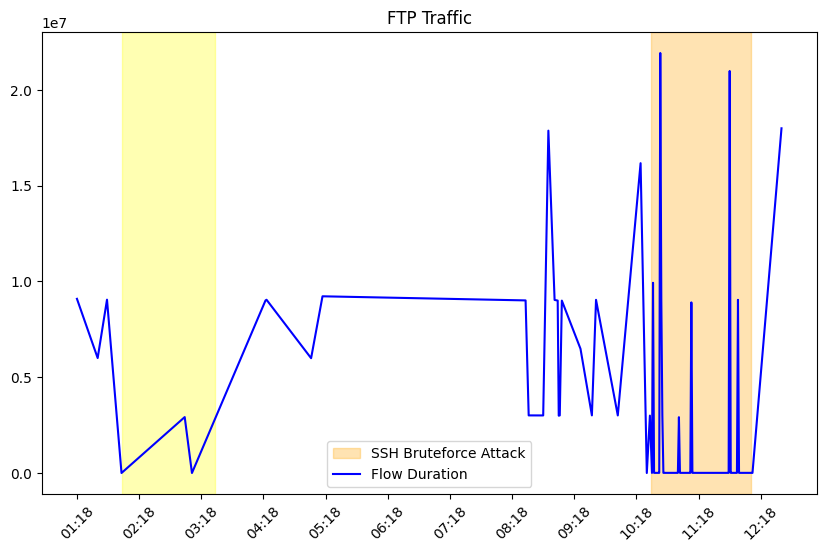

In [17]:
fig, ax = plot_packets(ftp_df, 'FTP Traffic')

### Saving filtered data

In [18]:
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

with open(PROCESSED_DATA_DIR / 'filtered_df.pkl', 'wb') as f:
    pickle.dump([
        all_df,
        ssh_df,
        ftp_df
        ], f)